# Learning to Classify Text with NLTK

This notebooks explores **supervised text classification** using the NLTK library, as outlined in [Chapter 6: Learning to Classify Text](https://www.nltk.org/book/ch06.html) of the introductory text to Natural Language Processing (NLP).
<br><br>
Within NLP text classification is used to identify spam, categorise topics by adding keywords, and disambiguating word sense for information retrieval in search engines and question answering in dialogue systems.
<br><br>

Building supervised classifiers involves:
* training classifer on a labelled corpus
* assessing quality - performance metrics and error analysi.
* making predictions about unseen data.

The aim here is to become familiar with text classification using the NLTK library.

## Question 6.5 
Select one of the classification tasks described in this chapter, such as name gender detection, document classification, part-of-speech tagging, or dialog act classification. 
* Using the same training and test data, and the same feature extractor, build three classifiers for the task: a decision tree, a naive Bayes classifier, and a Maximum Entropy classifier. 
* Compare the performance of the three classifiers on your selected task. 
* How do you think that your results might be different if you used a different feature extractor?

In [1]:
import nltk, re # NLTK library of language resources
nltk.download(["names"]) # labelled corpus of male and female names

# Data processing and visualisation
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

# Pandas and print rounding
pd.set_option('precision', 3) 
%precision 3

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package names to /usr/share/nltk_data...
[nltk_data]   Package names is already up-to-date!


/kaggle/input/images/output.png
/kaggle/input/images/development.png


## Gender Identification
The NLTK Names Corpus contains two files with male and female names.

### 1. Exploratory data analysis (EDA)


In [2]:
# load the data
names = nltk.corpus.names
names.fileids()

['female.txt', 'male.txt']

In [3]:
# Create lists of female and male names
f_names = names.words("female.txt")
m_names = names.words("male.txt")

# Calculate the number of female and male names
n_female =len(f_names)
n_male = len(m_names)
n_total  = n_female + n_male

# Look at the gender neutral names (overlap of two sets)
neutral_names = set(f_names).intersection(set(m_names))

# Calculate number of gender neutral names
n_neutral = len(neutral_names)

print("There are {} female, {} male {} total names.".format(n_female, n_male, n_total),end ="\n\n")
print("{} names appear in both categories and can be classified as gender neutral.".format(n_neutral),end="\n\n")
print("Female and male names make up {:.1f} and {:.1f}% of the corpus; {:.1f}% are gender neutral.".format(100*n_female/n_total, 100*n_male/n_total,100*n_neutral/n_total))

There are 5001 female, 2943 male 7944 total names.

365 names appear in both categories and can be classified as gender neutral.

Female and male names make up 63.0 and 37.0% of the corpus; 4.6% are gender neutral.


The presence of gender neutral names renders this a ternary, rather than binary, classification task. 
* Removing the gender neutral names from the male and female categories and introducing a third category seems sensible. 

* Care is necessary in splitting the corpus into train and test subsets to ensure these contain sufficient cases of the low frequency label, and in proportion to its probability. 

* The NLTK authors advise a minimum of 50 labels for any category in a subset. *To ensure this minimum at least one seventh of the data needs to be reserved for the test set, i.e. 1000 samples.*

In [4]:
# Remove gender neutral names from male and female names
m_names_only = sorted(set(m_names)-set(neutral_names))
f_names_only = sorted(set(f_names)-set(neutral_names))
n_names_only = sorted(neutral_names)

# Recalculate the number of names in each cateogory
n_female = len(f_names_only)
n_male = len(m_names_only)
n_total = n_female+n_male+n_neutral

print("Of {} total names {} are female, {} are male and {} are gender neutral.".format(n_total,n_female,n_male,n_neutral),end="\n\n")
print("This corresponds to {:.1f}, {:.1f} and {:.1f}% respectively.".format(100*n_female/n_total,100*n_male/n_total,100*n_neutral/n_total))

Of 7579 total names 4636 are female, 2578 are male and 365 are gender neutral.

This corresponds to 61.2, 34.0 and 4.8% respectively.


In [5]:
# Create a list of labelled names
labeled_names = ([(name, 'female') for name in f_names_only]
                 + [(name, 'male') for name in m_names_only]
                 + [(name, 'neutral') for name in n_names_only])

As seen previously, male and female names are more likely to start/ end with some letters. This EDA is extended to to include gender neutral names.

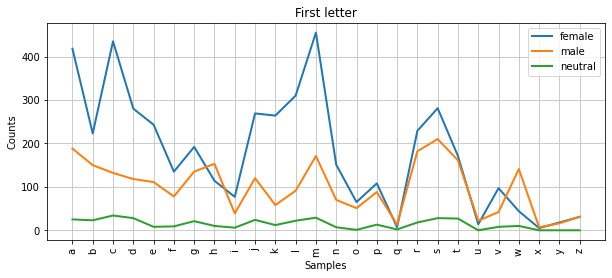

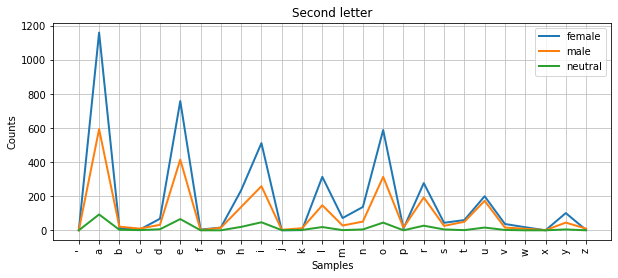

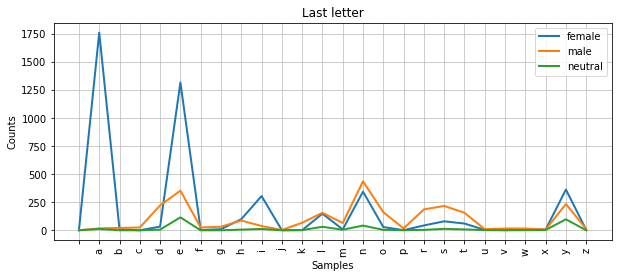

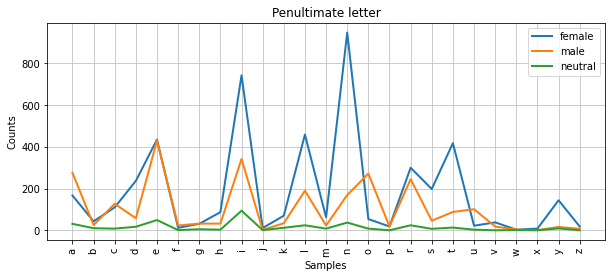

<AxesSubplot:title={'center':'Penultimate letter'}, xlabel='Samples', ylabel='Counts'>

In [6]:
# Make conditional frequency distributions to compare frequency of different letters 
# first letter
cfd_names_a1 = nltk.ConditionalFreqDist((label,name[0].lower()) for (name,label) in labeled_names)
# second letter
cfd_names_a2 = nltk.ConditionalFreqDist((label,name[1].lower()) for (name,label) in labeled_names)
# last letter
cfd_names_s1 = nltk.ConditionalFreqDist((label,name[-1].lower()) for (name,label) in labeled_names)
# penultimate letter
cfd_names_s2 = nltk.ConditionalFreqDist((label,name[-2].lower()) for (name,label) in labeled_names)

# Plot the freqencies
#fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(16, 16), sharex=True, sharey=True)
plt.figure(figsize=(10, 4))
cfd_names_a1.plot(title = "First letter")
plt.figure(figsize=(10, 4))
cfd_names_a2.plot(title = "Second letter")
plt.figure(figsize=(10, 4))
cfd_names_s1.plot(title = "Last letter")
plt.figure(figsize=(10, 4))
cfd_names_s2.plot(title = "Penultimate letter")

#plt.show()

Female, male and neutral names have different freqency distributions for the first, second, penultimate and last letters, e.g. female names commonly end in a or e, male names commonly end in e, i, l, o or r, and gender neutral names most commonly end in i. These differences can help to identify gender.

#### Length of names for each category

In [7]:
# compare name lengths across categories
name_lengths = [(label,len(name)) for (name,label) in labeled_names]

# Make a dataframe with name length and label as columns
df_lengths = pd.DataFrame.from_dict({"length":[len(name) for (name,label) in labeled_names],
              "label": [label for (name,label) in labeled_names]})

# Calculate cfd and convert to dataframe for easier plotting
cfd_length = nltk.ConditionalFreqDist(name_lengths)
df_length = pd.DataFrame(cfd_length).fillna(0).sort_index()

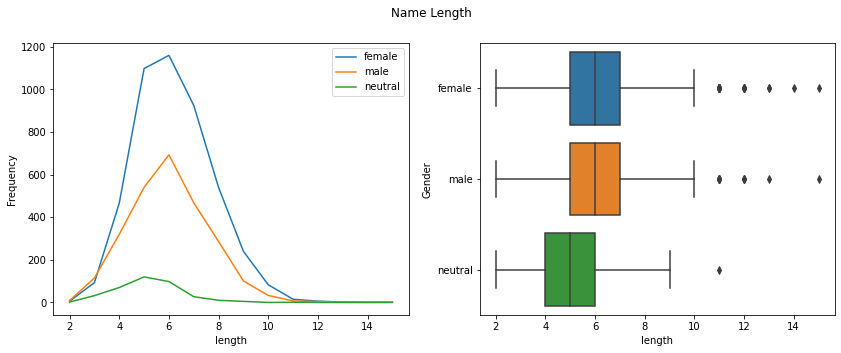

In [8]:
# Plot name length distribution for each gender
fig = plt.figure(figsize =(14,5)) # create figure

ax0 = fig.add_subplot(1,2,1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1,2,2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

# Subplot 1: Line plot
df_length.plot(ax=ax0) # add to subplot 2
ax0.set_ylabel('Frequency')
ax0.set_xlabel('length')

# Subplot 2: Box plot
sns.boxplot(x = df_lengths['length'], y = df_lengths["label"], ax= ax1)
ax1.set_ylabel("Gender")

plt.suptitle("Name Length")
#plt.savefig('name.png')
plt.show()

Gender neutral names appear to be shorter in length than female or male names.

#### Vowel fraction for each name category

In [9]:
# Use regular expression to count vowels, e.g.
name = 'Jennifer Anniston'
len(re.findall(r'[aeiouAEIOU]',name))

6

In [10]:
# compare proportion of vowels
vowels = [(label,round(len(re.findall(r'[aeiouAEIOU]',name))/len(name),1)) for (name,label) in labeled_names]
cfd_vowels = nltk.ConditionalFreqDist(vowels)
df_cfd_vowels = pd.DataFrame(cfd_vowels).fillna(0).sort_index()

df_vowels = pd.DataFrame.from_dict({"vowel_fraction":[round(len(re.findall(r'[aeiouAEIOU]',name))/len(name),1) for (name,label) in labeled_names],
              "label": [label for (name,label) in labeled_names]})

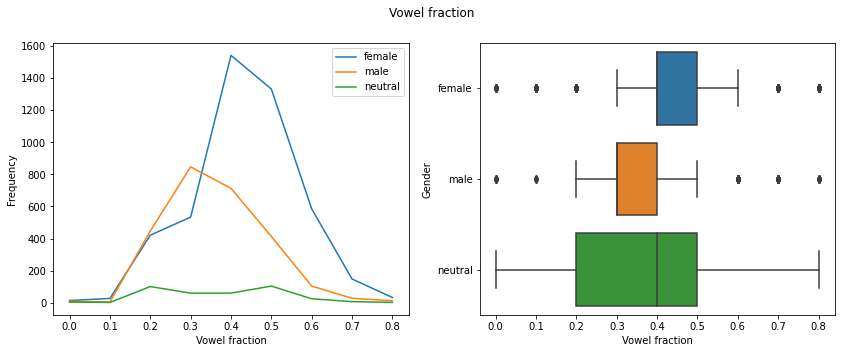

In [11]:
# Plot vowel fraction distribution for each gender
fig = plt.figure(figsize =(14,5)) # create figure

ax0 = fig.add_subplot(1,2,1) # add subplot 1 (1 row, 2 columns, first plot)
ax1 = fig.add_subplot(1,2,2) # add subplot 2 (1 row, 2 columns, second plot). See tip below**

#df_length = pd.DataFrame(cfd_length).fillna(0).sort_index()
df_cfd_vowels.plot(ax = ax0)
ax0.set_ylabel('Frequency')
ax0.set_xlabel('Vowel fraction')

sns.boxplot(x = df_vowels['vowel_fraction'], y = df_lengths["label"], ax = ax1)
ax1.set_ylabel("Gender")
ax1.set_xlabel("Vowel fraction")

plt.suptitle("Vowel fraction")
#plt.savefig('name.png')

plt.show()

### 2. Data preprocessing
#### Split data into train, development test and test sets.

* Split the data into development and test sets, where the development set is itself split into training and development test set.
* Model and feature selection is an iterative process, train and development test sets help to evaluate accuaracy.

In [12]:
# shuffle the dataset
import random
random.shuffle(labeled_names)

# labeled_names is the list of tuples containing name-label pairs
print(labeled_names[:25])

# Split datasets for training and model evaluation
train_names = labeled_names[2500:]
devtest_names = labeled_names[1250:2500]
test_names = labeled_names[:1250]

[('Bobby', 'neutral'), ('Selestina', 'female'), ('Aron', 'male'), ('Chancey', 'male'), ('Martyn', 'male'), ('Eolanda', 'female'), ('Cliff', 'male'), ('Siana', 'female'), ('Giraud', 'male'), ('Vergil', 'male'), ('Fidela', 'female'), ('Laurens', 'male'), ('Rheba', 'female'), ('Katrinka', 'female'), ('Kelcie', 'female'), ('Guendolen', 'female'), ('Jonell', 'female'), ('Veronike', 'female'), ('Norwood', 'male'), ('Lacey', 'female'), ('Russ', 'male'), ('Delcina', 'female'), ('Goldi', 'female'), ('Onida', 'female'), ('Fortune', 'female')]


#### Create the feature set
A dictionary of encoded features - simple value types (booleans/ numbers/ strings). 

In [13]:
# function to create the feature set

def gender_features(word):
    #return a dictionary with feature name-value pairs
    return {'affix1' : word[0].lower(),
            'affix2' : word[:1].lower(),
            'suffix1': word[-1].lower(),
            'suffix2': word[-2:].lower(),
            'length' : len(word),
            'vowel_ratio': round(len(re.findall(r'[aeiouAEIOU]',word))/len(word),1)
           }

gender_features("Erin")
#notice the output is a dictionary

{'affix1': 'e',
 'affix2': 'e',
 'suffix1': 'n',
 'suffix2': 'in',
 'length': 4,
 'vowel_ratio': 0.500}

In [14]:
# Create features sets for each subset
train_set = [(gender_features(n), gender) for (n, gender) in train_names]
devtest_set = [(gender_features(n), gender) for (n, gender) in devtest_names]
test_set = [(gender_features(n), gender) for (n, gender) in test_names]

# Check number of samples for each category in test set.
print(len([tag for (name,tag) in test_set if tag=="neutral"]))
print(len([tag for (name,tag) in test_set if tag=="male"]))
print(len([tag for (name,tag) in test_set if tag=="female"]))

54
426
770


### Train model, make predictions, check accuracy

In [15]:
# train a Naive Bayes classifier
classifier = nltk.NaiveBayesClassifier.train(train_set)

# Check if it works on examples
names = ["Ksenia","Mattia", "Erin"]
for name in names:
    print("{} is a {} name.".format(name,classifier.classify(gender_features(name))))

# Evaluate overall accuracy
accuracy = nltk.classify.accuracy(classifier, devtest_set)
print("The classifier is {:.1f}% accurate.".format(100*accuracy))

Ksenia is a female name.
Mattia is a female name.
Erin is a male name.
The classifier is 76.3% accurate.


Mattia is an Italian male name - cultural/ regional differences are at play here; the dataset is not representative of common names in other languages.

### Analyse important features

In [16]:
# what was the best way to classify?
classifier.show_most_informative_features(50)

Most Informative Features
                 suffix2 = 'ia'           female : male   =     64.4 : 1.0
                 suffix1 = 'k'              male : female =     54.4 : 1.0
                 suffix2 = 'la'           female : male   =     53.3 : 1.0
                 suffix2 = 'us'             male : female =     52.9 : 1.0
                 suffix1 = 'a'            female : male   =     46.2 : 1.0
                 suffix2 = 'rt'             male : female =     39.0 : 1.0
                 suffix2 = 'ta'           female : male   =     31.8 : 1.0
                 suffix2 = 'ld'             male : female =     26.2 : 1.0
                 suffix2 = 'na'           female : neutra =     22.8 : 1.0
                 suffix2 = 'at'           neutra : female =     20.8 : 1.0
                 suffix2 = 'ch'             male : female =     20.4 : 1.0
                 suffix2 = 'do'             male : female =     20.4 : 1.0
                 suffix2 = 'rd'             male : female =     18.4 : 1.0

Most informative features show that the likelihood ratios are highest for one- and two-letter suffixes. The model can help to determine the most important features.

It can also help to look at errors.

In [17]:
# print it out by looping and making it nice looking:
# for (tag, guess, name) in sorted(classifier.errors):
#    print('correct={:<8} guess={:<8s} name={:<30}'.format(tag, guess, name))

In [18]:
# train the classifier
classifier_NB = nltk.NaiveBayesClassifier.train(train_set)
classifier_ME = nltk.MaxentClassifier.train(train_set)
classifier_DT = nltk.DecisionTreeClassifier.train(train_set)

print(nltk.classify.accuracy(classifier, devtest_set))
print(classifier_NB.show_most_informative_features(10))
print(classifier_ME.show_most_informative_features(10))
#print(classifier_DT.show_most_informative_features(10))



  ==> Training (100 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -1.09861        0.047
             2          -0.52339        0.752
             3          -0.45181        0.790
             4          -0.41411        0.795
             5          -0.39149        0.797
             6          -0.37663        0.800
             7          -0.36620        0.801
             8          -0.35852        0.804
             9          -0.35263        0.804
            10          -0.34798        0.805
            11          -0.34422        0.806
            12          -0.34110        0.805
            13          -0.33848        0.807
            14          -0.33625        0.806
            15          -0.33431        0.806
            16          -0.33262        0.807
            17          -0.33113        0.808
            18          -0.32981        0.808
            19          -0.32862        0.808
 

In [19]:
# Test accuracy
accuracy_NB = nltk.classify.accuracy(classifier_NB, devtest_set)
accuracy_ME = nltk.classify.accuracy(classifier_ME, devtest_set)
accuracy_DT = nltk.classify.accuracy(classifier_DT, devtest_set)
print("The NB classifier is {:.1f}% accurate.".format(100*accuracy_NB))
print("The ME classifier is {:.1f}% accurate.".format(100*accuracy_ME))
print("The DT classifier is {:.1f}% accurate.".format(100*accuracy_DT))

# Test examples
names = ["Robert","Elizabeth","Ksenia","Mattia"]

print("\nNaive Bayes model predicts:\n")
for name in names:
    print("{} is a {} name.".format(name,classifier_NB.classify(gender_features(name))))

print("\nMax Entropy model predicts:\n")
for name in names:
    print("{} is a {} name.".format(name,classifier_ME.classify(gender_features(name))))

print("\nDecision Tree model predicts:\n")    
for name in names:
    print("{} is a {} name.".format(name,classifier_DT.classify(gender_features(name))))

The NB classifier is 76.3% accurate.
The ME classifier is 78.2% accurate.
The DT classifier is 74.6% accurate.

Naive Bayes model predicts:

Robert is a male name.
Elizabeth is a female name.
Ksenia is a female name.
Mattia is a female name.

Max Entropy model predicts:

Robert is a male name.
Elizabeth is a female name.
Ksenia is a female name.
Mattia is a female name.

Decision Tree model predicts:

Robert is a male name.
Elizabeth is a female name.
Ksenia is a female name.
Mattia is a female name.


### Evaluate classifier performance and compare models
* Accuracy
* Precision
* Recall
* R-f

In [20]:
# Add model evaluation code

## Guessing name gender randomly
Based on name gender frequencies gender labels can be generated randomly using the multinomial distribution.

In [21]:
# Generate random labels from numpy multinomial distribution
rng = np.random.default_rng()
simulated_labels = rng.multinomial(1, [.612, .340, .048],size=7579)
df_simulated = pd.DataFrame(simulated_labels,columns = ["female","male","neutral"],index = [name for (name,label) in labeled_names])
df_simulated["random"] = ""

for index, row in df_simulated.iterrows():
    df_simulated.loc[index,"random"] = [col for col in ["female","male","neutral"] if row[col]==1][0]
    
df_simulated["label"] = [label for (name,label) in labeled_names]

df_simulated.head()

,female,male,neutral,random,label
Bobby,0,1,0,male,neutral
Selestina,0,1,0,male,female
Aron,0,1,0,male,male
Chancey,1,0,0,female,male
Martyn,1,0,0,female,male


In [22]:
#check accuracy of randomly generated name gender labels
count_accurate = 0
for (index, row) in df_simulated.iterrows():
    if row["random"]==row["label"]:
        count_accurate +=1 
accuracy = count_accurate/len(df_simulated)
accuracy


0.498

Randomly guessing gender gives an accuracy of circa 50%. This provides a baseline for improving and comparing the classifier.

As the most common name in the corpus is female, always guessing female gives an even higher model accuracy.

In [23]:
# Always guess name gender to be female
df_simulated["always_female"] = "female"
#check accuracy
count_accurate = 0
for (index, row) in df_simulated.iterrows():
    if row["always_female"]==row["label"]:
        count_accurate +=1 
accuracy = count_accurate/len(df_simulated)
accuracy

0.612

Always guessing the gender to be female gives an accuracy of 61%.

### Cross validation

## REFERENCES
* Bird, Steven, Edward Loper and Ewan Klein (2009). [Natural Language Processing with Python](https://www.nltk.org/book/).  O'Reilly Media Inc.

Code examples and exercises from NLTK introductory chapters were covered in:
* notebook [Natural Language TookKit: Getting Started](https://www.kaggle.com/code/ksenia5/natural-language-toolkit-getting-started)
* notebook [NLTK Categorising and Tagging Words](https://www.kaggle.com/ksenia5/nltk-categorising-and-tagging-words)